# **Notebook to generate radar plots with grouped CP features**
- similar to published here: https://pubmed.ncbi.nlm.nih.gov/35390365/

**What are the inputs necessary to run this notebook?**
- A csv with CellProfiler features as input
- Metadata features starting with "Metadata_" prefix
        
## Steps:

1. Prepare a csv with preprocessed features (e.g. z-scores)
2. Group the features up to the level you want to show them (e.g. compound+dose)
3. Choose the information to plot
4. Visualize!

# **1. Import libraries and figure format settings**

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
import plotly.graph_objects as go
import math
#import ipywidgets as widgets

from math import pi

%matplotlib inline

In [6]:
# display settings
pd.set_option("max_colwidth", 60)
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 10) 

In [7]:
# format for saving images
figformat = 'png'
dpi = 150
cmap = "viridis"

# **2. Define inputs and outputs**

In [33]:
# Set current working directory
print(os.getcwd())

/home/jovyan/jonne/Feature_Analysis/2023/Feature_Analysis_SSS-val-A549-v2-JR


In [34]:
# set output directory
OutputDir = "./radarplots/" 
if not os.path.exists(OutputDir):
    os.makedirs(OutputDir)

In [56]:
# Import feature data in csv format or parquet format

input_file = "output/level7_modz_consensus_df_perwell.parquet"

file_extension = os.path.splitext(input_file)[1]
if file_extension == '.csv':
    features_df = pd.read_csv(input_file)
elif file_extension == '.parquet':
    features_df = pd.read_parquet(input_file)
else:
    raise ValueError(f"Unsupported file format: {file_extension}")

features_df.head(2)

,Metadata_plate_map_name,Metadata_cmpdName,Metadata_cmpdConc,...,Cells_RadialDistribution_ZernikePhase_RNA_9_5,Cells_RadialDistribution_ZernikePhase_RNA_9_7,Cells_RadialDistribution_ZernikePhase_RNA_9_9
0,P103555,BJ1894069,0.300000,...,-0.095208,-0.280153,-0.179067
1,P103555,BJ1894069,3.333333,...,0.131934,-0.258342,-0.049168


In [57]:
#------------- plates ----------------#
selected_plates = ["P103573","P103587","P103588"]
features_df = features_df[~features_df['Metadata_plate_map_name'].isin(selected_plates)]

# ----------- compounds ---------------#
selected_compounds = ["DMSO", "uninfected","DD4386006","DO8167002","DI1202001","[fenb]","[etop]"]
features_df = features_df[features_df['Metadata_cmpdName'].isin(selected_compounds)]

# **3. group features**

In [58]:
# Remove non-data features from the list
ListOfFeatures = list(features_df.columns[~features_df.columns.str.contains("Metadata_")])
ListOfMetadata = list(features_df.columns[features_df.columns.str.contains("Metadata_")])

In [59]:
print("Number of features in the provided data file: {}".format(len(features_df.columns)))

Number of features in the provided data file: 1193


In [60]:
# group all the features into biologically relevant groups

def group_features(feature_name):
    channels = ["ER", "DNA", "RNA", "AGP", "Mito"]
    
    if "AreaShape" in feature_name:
        if "Nuclei" in feature_name:
            return "AreaShape_Nuclei"
        elif "Cytoplasm" in feature_name:
            return "AreaShape_Cytoplasm"
        elif "Cells" in feature_name:
            return "AreaShape_Cells"

    for channel in channels:
        if channel in feature_name:
            if "Intensity" in feature_name:
                return f"{channel}_Intensity"
            elif "Granularity" in feature_name:            
                return f"{channel}_Granularity"
            elif "RadialDistribution" in feature_name:
                return f"{channel}_RadialDistribution"
        
    if "Neighbors" in feature_name:
        if "Cells" in feature_name:
            return "Neighbors_Cells"
        elif "Nuclei" in feature_name:
            return "Neighbors_nuclei"

    if "Children" in feature_name:
        if "Nuclei" in feature_name:
            return "Children_nuclei"

    if "Correlation" in feature_name:
        parts = feature_name.split('_')
        found_channels = [part for part in parts if part in channels]
        sorted_channels = sorted(found_channels)
        sorted_feature_name = '_'.join(['Correlation'] + sorted_channels)
        if len(sorted_channels) == 2:
            return f'correlation_{sorted_channels[0]}_{sorted_channels[1]}'
    return "Uncategorized"

grouping                  = pd.DataFrame(ListOfFeatures, columns=['Feature_name'])
grouping["Feature_group"] = grouping["Feature_name"].apply(group_features)
grouping.set_index("Feature_name", inplace=True)

feature_mapping = {
    'DNA_Intensity': ['DNA', 'Intensity', 'I'],
    'DNA_Granularity': ['DNA', 'Granularity', 'G'],
    'DNA_RadialDistribution': ['DNA', 'RadialDistribution', 'RD'],
    'ER_Intensity': ['ER', 'Intensity', 'I'],
    'ER_Granularity': ['ER', 'Granularity', 'G'],
    'ER_RadialDistribution': ['ER', 'RadialDistribution', 'RD'],
    'RNA_Intensity': ['RNA', 'Intensity', 'I'],
    'RNA_Granularity': ['RNA', 'Granularity', 'G'],
    'RNA_RadialDistribution': ['RNA', 'RadialDistribution', 'RD'],
    'AGP_Intensity': ['AGP', 'Intensity', 'I'],
    'AGP_Granularity': ['AGP', 'Granularity', 'G'],
    'AGP_RadialDistribution': ['AGP', 'RadialDistribution', 'RD'],
    'Mito_Intensity': ['MITO', 'Intensity', 'I'],
    'Mito_Granularity': ['MITO', 'Granularity', 'G'],
    'Mito_RadialDistribution': ['MITO', 'RadialDistribution', 'RD'],
    'AreaShape_Cells': ['AreaShape', 'AreaShape', 'C'],
    'AreaShape_Nuclei': ['AreaShape', 'AreaShape', 'N'],
    'AreaShape_Cytoplasm': ['AreaShape', 'AreaShape', 'Cy'],
    'Neighbors_Cells': ['Neighbors', 'Neighbors', 'C'],
    'Neighbors_nuclei': ['Neighbors', 'Neighbors', 'N'],
    'correlation_AGP_DNA': ['Correlation', 'Correlation', 'A/D'],
    'correlation_AGP_ER': ['Correlation', 'Correlation', 'A/E'],
    'correlation_AGP_Mito': ['Correlation', 'Correlation', 'A/M'],
    'correlation_AGP_RNA': ['Correlation', 'Correlation', 'A/R'],
    'correlation_DNA_ER': ['Correlation', 'Correlation', 'D/E'],
    'correlation_DNA_Mito': ['Correlation', 'Correlation', 'D/M'],
    'correlation_DNA_RNA': ['Correlation', 'Correlation', 'D/R'],
    'correlation_ER_Mito': ['Correlation', 'Correlation', 'E/M'],
    'correlation_ER_RNA': ['Correlation', 'Correlation', 'E/R'],
    'correlation_Mito_RNA': ['Correlation', 'Correlation', 'M/R'],
    'Children_nuclei': ['Children', 'Children', 'N'],
    'Uncategorized': ['Uncategorized', 'Uncategorized', 'x']
}

grouping[['main_module', 'module', 'letter']] = grouping['Feature_group'].map(feature_mapping).apply(pd.Series)
grouping.head(2)

,Feature_group,main_module,module,letter
Feature_name,,,,
Nuclei_AreaShape_Eccentricity,AreaShape_Nuclei,AreaShape,AreaShape,N
Nuclei_AreaShape_Extent,AreaShape_Nuclei,AreaShape,AreaShape,N


In [61]:
grouping_Feature_name = grouping[["Feature_group"]]

In [62]:
summary_table = grouping.groupby('Feature_group').size().reset_index(name='Count')
summary_table = summary_table.sort_values(by='Count', ascending=False)
summary_table

,Feature_group,Count
19,RNA_RadialDistribution,176
2,AGP_RadialDistribution,172
14,Mito_RadialDistribution,159
8,DNA_RadialDistribution,157
11,ER_RadialDistribution,138
...,...,...
6,DNA_Granularity,3
12,Mito_Granularity,2
16,Neighbors_nuclei,2
20,Uncategorized,2


# **4. select primary grouping factor (each radar plot)**

In [63]:
def dropdown(input_list, multiple=False):
    import ipywidgets as widgets
    global dropdown_output

    if multiple:
        widget = widgets.SelectMultiple(
            options=input_list,
            description='Choose',
            disabled=False
        )
    else:
        widget = widgets.Dropdown(
            options=input_list,
            description='Choose',
            disabled=False
        )

    def dropdown_handler(change):
        global dropdown_output
        dropdown_output = change.new

    widget.observe(dropdown_handler, names='value')
    display(widget)
    dropdown_output = widget.value

In [64]:
# What level do you want to group your features on?
meta_list = [option for option in features_df.filter(regex=r'Metadata', axis=1).columns]

dropdown(meta_list, multiple=False)

Dropdown(description='Choose', options=('Metadata_plate_map_name', 'Metadata_cmpdName', 'Metadata_cmpdConc', '…

In [65]:
grouping_col = dropdown_output
print("we will group your features on the:", grouping_col, "feature")

we will group your features on the: Metadata_cmpdName feature


In [66]:
conditions_list = features_df[grouping_col].unique()
dropdown(conditions_list, multiple=True)

SelectMultiple(description='Choose', options=('DD4386006', 'DI1202001', 'DMSO', 'DO8167002', '[etop]', '[fenb]…

In [67]:
selected_conditions = dropdown_output
print("we will plot radarplots for:", selected_conditions)

we will plot radarplots for: ('DD4386006', 'DI1202001', 'DMSO', 'DO8167002', '[etop]', '[fenb]', 'uninfected')


# **5. what is a secondary grouping factor (levels within one radar plot)**

In [68]:
# What level do you want to group your features on?
meta_list = [option for option in features_df.filter(regex=r'Metadata', axis=1).columns]

dropdown(meta_list, multiple=False)

Dropdown(description='Choose', options=('Metadata_plate_map_name', 'Metadata_cmpdName', 'Metadata_cmpdConc', '…

In [69]:
secondary_grouping_col = dropdown_output
print("we will plot:", secondary_grouping_col, "as traces in your radar plot")

we will plot: Metadata_cmpdConc as traces in your radar plot


In [70]:
secondary_conditions_list = features_df[secondary_grouping_col].unique()
dropdown(secondary_conditions_list, multiple=True)

SelectMultiple(description='Choose', options=(np.float64(0.3), np.float64(3.333333), np.float64(10.0), np.floa…

In [71]:
selected_secondary_conditions = dropdown_output
print("we will plot radarplots for", secondary_grouping_col, "in selected ", selected_secondary_conditions)

we will plot radarplots for Metadata_cmpdConc in selected  (np.float64(0.3), np.float64(3.333333), np.float64(10.0), np.float64(30.0), np.float64(5.0), np.float64(0.008333), np.float64(0.033333), np.float64(0.1), np.float64(0.833333))


# **6. plot radars**

In [72]:
# to be able to transpose the df we need a 1-dimensional index. we concatenate the grouping columns and set it as index.
features_df['grouping_columns'] = features_df.apply(lambda row: f"{row[grouping_col]}_{row[secondary_grouping_col]}", axis=1)
features_df.set_index('grouping_columns', inplace=True)

# group the features based on selected conditions
grouped_df = features_df[ListOfFeatures].groupby(features_df.index).mean()

# take absolute values (we are interested in the importance of the feature group) 
transposed_df    = grouped_df.abs().transpose()

# Merge with grouping_Feature_name
df_merged                      = pd.merge(left=transposed_df, right=grouping_Feature_name, left_index=True, right_index=True, how='left')

# remove uncategorized features
df_filtered = df_merged[df_merged['Feature_group'] != 'Uncategorized']

# Group features and compute the mean
df_38cat                       = df_filtered.groupby('Feature_group').mean().round(decimals=5).transpose()

# Remove rows with infinite values
df_38cat                       = df_38cat.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Extract feature groups and create categories list
feature_groups                 = list(df_38cat.columns)
categories                     = [*feature_groups, feature_groups[0]]

# Extract primary and secondary grouping columns from index
df_38cat[grouping_col]           = df_38cat.index.str.split('_').str[0]
df_38cat[secondary_grouping_col] = df_38cat.index.str.split('_').str[1] #.astype(float)

# find highest values in df to set index
non_metadata_cols = df_38cat.loc[:, ~df_38cat.columns.str.contains("metadata")]
numeric_cols      = non_metadata_cols.select_dtypes(include=['number'])
highest_value     = numeric_cols.max().max()
range_max         = math.ceil(highest_value )

# find max number of doses per compound to assign colors
dose_counts_per_compound = df_38cat.groupby(grouping_col)[secondary_grouping_col].nunique()
max_colors               = dose_counts_per_compound.max()

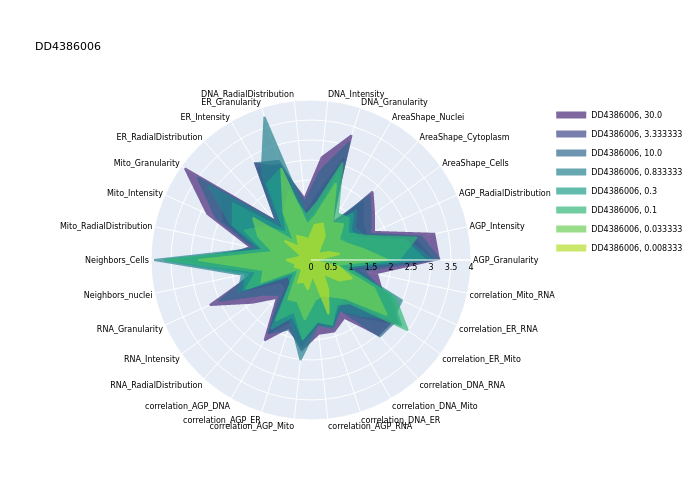

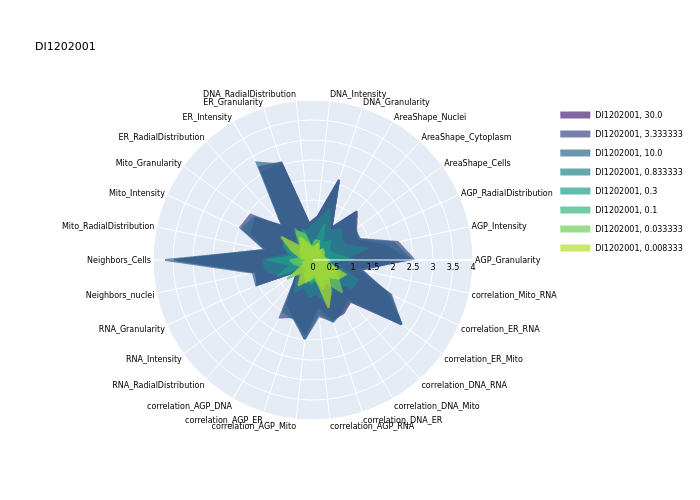

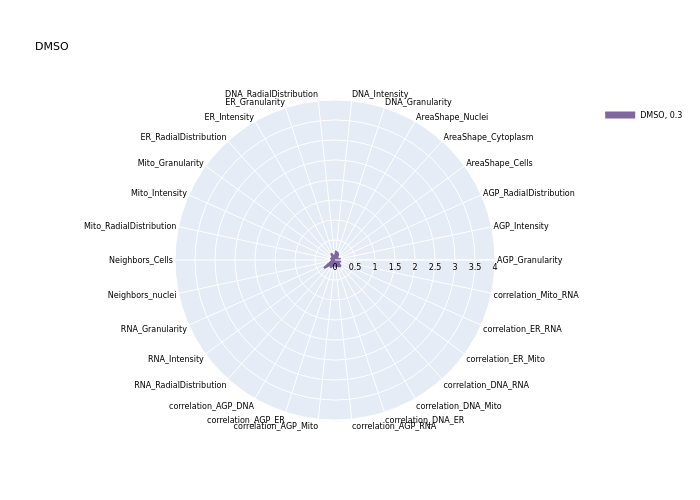

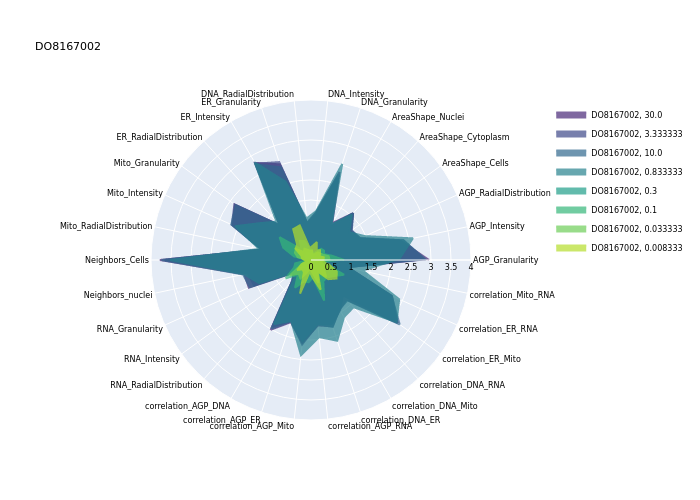

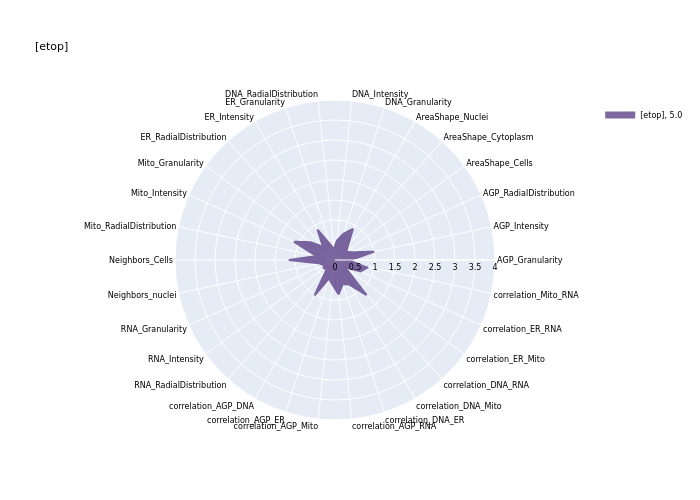

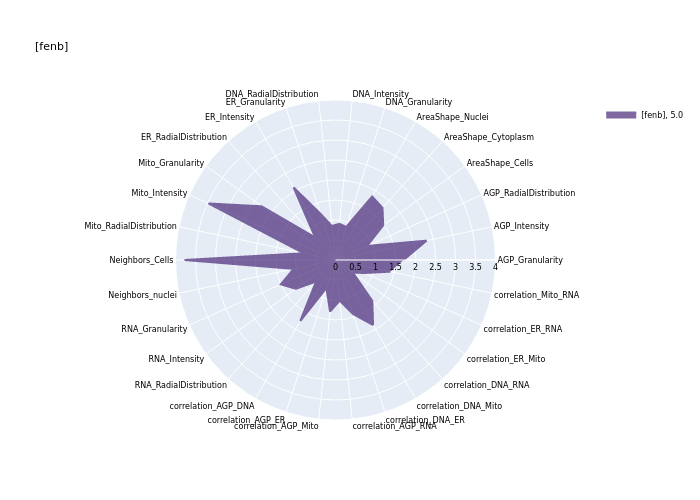

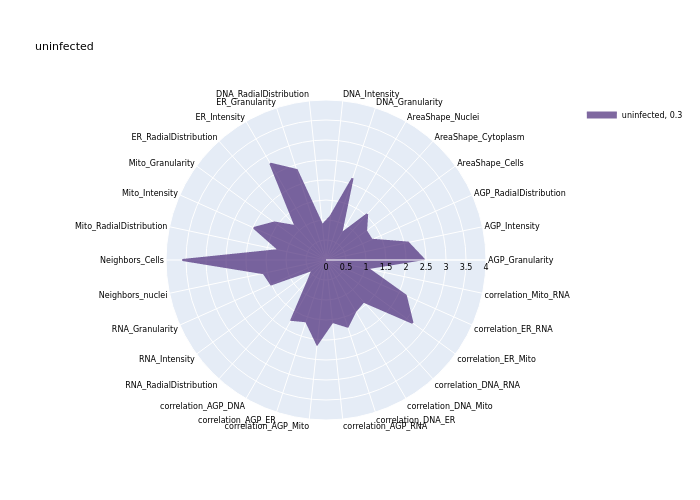

In [73]:
# plot radar plots

plot_colors = sns.color_palette(cmap, max_colors).as_hex()

for comp in selected_conditions:
    
    df_current = df_38cat[df_38cat[grouping_col] == comp].copy()
    compound_doses = sorted(set(df_current[secondary_grouping_col]), reverse=True)

    plot_traces = []

    for idx, dose in enumerate(compound_doses[:max_colors]):
        try:
            plot_color = plot_colors[idx % len(plot_colors)]
            comp_dose_data = df_current.loc[f"{comp}_{dose}"]

            radar_trace = go.Scatterpolar(
                r=comp_dose_data, theta=categories,
                fill='toself', opacity=0.7,
                line_color=plot_color, fillcolor=plot_color,
                connectgaps=True, name=f"{comp}, {dose}"
            )
            plot_traces.append(radar_trace)
        except KeyError:
            print(f"Data not available for {comp}_{dose}")


    radar_figure = go.Figure(data=plot_traces)
    radar_figure.update_layout(
        title_text=comp,
        polar={'radialaxis': {'visible': True, 'range': [0, range_max]}},
        font=dict(family="Arial, sans-serif", size=8, color="Black"),
        showlegend=True
    )

    radar_figure.show(renderer='png')
    radar_figure.write_image(f"{OutputDir}/radarplot_compound_{comp}.png")

# plot with colour legend in matplotlib

In [74]:
# prepare features for matplotlib plotting
categories_cp = grouping.drop_duplicates(subset=["Feature_group", "main_module", "module", "letter"], keep='first').reset_index(drop=True)


df_38cat_trans    = df_38cat.transpose()
df_38cat_trans    = df_38cat_trans.reset_index().rename(columns={'index': 'Feature_group'})
merged_df         = pd.merge(df_38cat_trans, categories_cp, on='Feature_group', how='inner')
merged_df_indexed = merged_df.set_index(['Feature_group', 'main_module', 'module', 'letter'])

In [75]:
def build_modules_dict(df):
    modules_dict = {}
    
    for _, row in df.iterrows():
        main_module = row['main_module']
        letter = row['letter']
        module = row['module']
        
        if main_module not in modules_dict:
            modules_dict[main_module] = {}
        
        if letter not in modules_dict[main_module]:
            modules_dict[main_module][letter] = []
        
        if module not in modules_dict[main_module][letter]:
            modules_dict[main_module][letter].append(module)
    
    return modules_dict

modules_dict = build_modules_dict(merged_df)

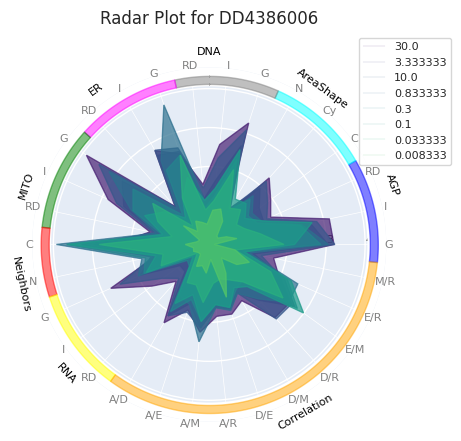

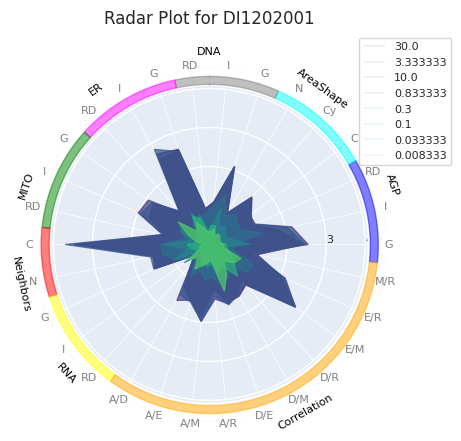

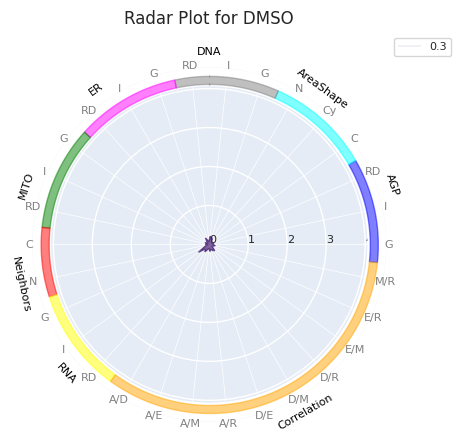

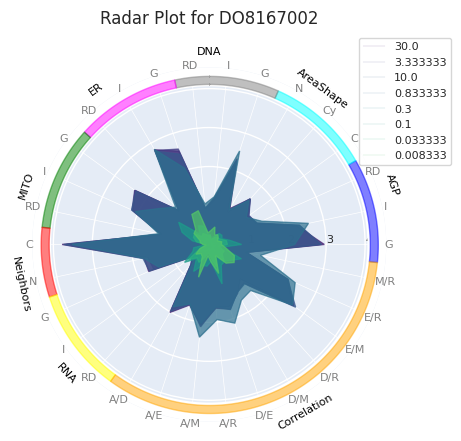

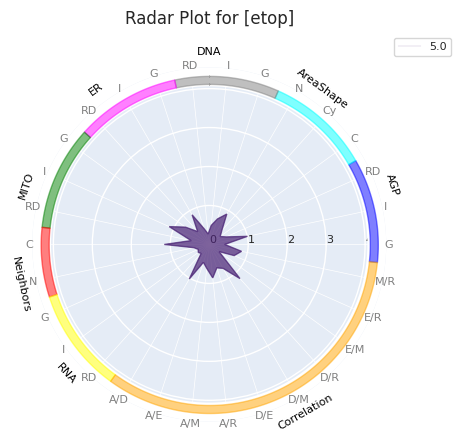

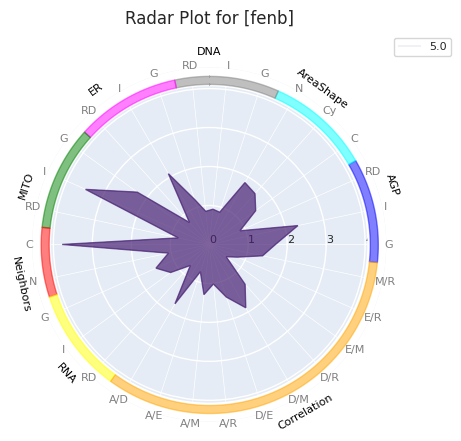

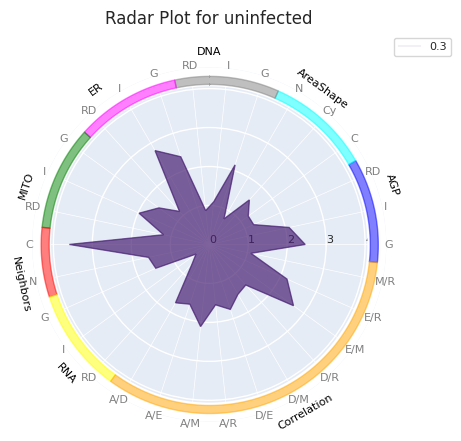

In [81]:
def radarplot_matplotlib(modules_dict, group_means, doses, title, max_value):
    modules = [module for module, subgroups in modules_dict.items() for _ in subgroups]
    submodules = [subgroup for module, subgroups in modules_dict.items() for subgroup in subgroups]

    num_vars = len(submodules)
    angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    colors_cat = ['blue', 'cyan', 'grey', 'magenta', 'green', 'red', 'yellow', 'orange', 'purple']

    ax.set_facecolor('#e5ecf6')
    
    total_subgroups = sum(len(subgroups) for subgroups in modules_dict.values())
    outer_edge_value = max_value * 1.03

    group_start_angles = {}
    current_angle = 0
    for group in modules_dict.keys():
        group_start_angles[group] = current_angle
        num_subgroups_in_group = len(modules_dict[group])
        current_angle += num_subgroups_in_group * (2 * pi / total_subgroups)

    angle_extension = 2 * pi / total_subgroups * -0.5

    narrow_inner_edge_value = outer_edge_value * 1.05

    for angle in angles[:-1]:
        ax.plot([angle, angle], [0, outer_edge_value], color='white', linewidth=0.5, zorder=0)  
    
    for group, color in zip(modules_dict.keys(), colors_cat):
        start_angle = group_start_angles[group]
        num_subgroups_in_group = len(modules_dict[group])
        end_angle = start_angle + num_subgroups_in_group * (2 * pi / total_subgroups)
    
        extended_start_angle = (start_angle + angle_extension) % (2 * pi)
        extended_end_angle = (end_angle + angle_extension) % (2 * pi)
    
        if extended_start_angle < extended_end_angle:
            segment_angles = np.linspace(extended_start_angle, extended_end_angle, 100)
        else:
            segment_angles = np.concatenate((np.linspace(extended_start_angle, 2 * pi, 50), np.linspace(0, extended_end_angle, 50)))
    
        ax.fill_between(segment_angles, narrow_inner_edge_value, outer_edge_value, color=color, alpha=0.5, zorder=3)

    colors_doses = ['#482173','#433e85','#38588c','#2d708e','#25858e','#1e9b8a','#2ab07f','#52c569','#86d549','#c2df23']
    
    for means, dose, color in zip(group_means, doses, colors_doses):
        means += means[:1]  
        ax.plot(angles, means, color=color, linewidth=0.1, zorder=4, label=dose)  
        ax.fill(angles, means, color=color, alpha=0.7, zorder=4)

    radial_interval = max(1, int(max_value / 5))  
    radial_values = np.arange(0, max_value + radial_interval, radial_interval)
    ax.set_rgrids(radial_values, angle=0, fontsize=8)


    ax.xaxis.grid(True, zorder=0)
    ax.yaxis.grid(True, linestyle='-', linewidth=1, color='white', alpha=1, zorder=0)

    for angle, label in zip(angles[:-1], submodules):
        ax.text(angle, outer_edge_value * 1.12, label, 
                horizontalalignment='center', verticalalignment='center', 
                fontsize=8, color='gray', zorder=4)  

    label_distance = outer_edge_value * 1.2
    for module, start_angle in group_start_angles.items():
        num_subgroups_in_group = len(modules_dict[module])
        group_angle_span = num_subgroups_in_group * (2 * pi / total_subgroups)
        midpoint_angle = start_angle + group_angle_span / 2

        rotation = np.degrees(midpoint_angle) + 90 if midpoint_angle >= pi else np.degrees(midpoint_angle) - 90

        ax.text(midpoint_angle, label_distance, module,
                horizontalalignment='center', verticalalignment='center',
                rotation=rotation, fontsize=8, color='black', rotation_mode='anchor', zorder=4) 

    ax.spines['polar'].set_visible(False)
    ax.set_xticks([])

    inner_circle = plt.Circle((0, 0), narrow_inner_edge_value, transform=ax.transData._b, color='white', fill=False, linewidth=15, zorder=2)
    ax.add_artist(inner_circle)

    plt.subplots_adjust(top=0.7)  
    plt.title(title, size=12, y=1.1)  

    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=8) 

    plt.show()


compound_groups = {}
for column in merged_df_indexed.columns:
    compound_name = column.split('_')[0]  
    if compound_name not in compound_groups:
        compound_groups[compound_name] = []
    compound_groups[compound_name].append(column)


for compound, columns in compound_groups.items():
    group_means = [merged_df_indexed[column].tolist() for column in columns]
    doses = [column.split('_')[1] for column in columns]
    
    group_means.reverse()
    doses.reverse()

    radarplot_matplotlib(modules_dict, group_means, doses, title=f"Radar Plot for {compound}", max_value=range_max)

__end